In [1]:
#meta: 4/30/2020 Ex3 Multiclass Classification and Neural Networks.  
# One-vs-all logistic regression and intro to neural nets - recognize hand-written digits.  
# src Coursera, Standford ML course - refactor in python
# src for markup  https://github.com/dibgerge/ml-coursera-python-assignments.git
#see ex3.pdf
#Numbering per original assignments

#here 04/30/2020 One-vs-all Logistic Regression
#      numpy for data load (not pandas)
#      Reuse ML functions: myUtils.ml - sigmoid(), costFunctionReg() already vectorized
#      Write OneVsAll to train multiclass classifier - return all_thetas
#      Write predictOneVsAll() for multiclass - return a vector of predictions for each example in the matrix X. 
#      Reflection: Multiclass Logistic Regression is great, but still only linear in nature
#
#      Implement a neural network - intro (with already trained theta params)
#      The neural network will be able to represent complex models that form non-linear hypotheses.
#      Rewrite predict() for multiclass
#      Implement the feedforward propagation algorithm to use our weights for prediction. 
#
#      Next week: will write the backpropagation algorithm for learning the neural network parameters.


In [2]:
import numpy as np

#io
from scipy.io import loadmat

# Plot
import matplotlib.pyplot as plt
%matplotlib inline

# Optimization module in scipy
from scipy import optimize

#import my utils
from myUtils import ml as myML  # my own module


Use logistic regression implement one-vs-all logistic regression and neural networks to recognize handwritten digits (from 0 to 9). 

# 1. Multiclass Classification


## Recognize Handwritten Digits
Automated handwritten digit recognition is widely used today - from recognizing zip codes (postal codes)
on mail envelopes to recognizing amounts written on bank checks. This exercise will show you how the methods you have learned can be used for this classification task.

In the first part of the exercise, you will extend your previous implementation of logistic regression and apply it to one-vs-all classification.


## 1.1 Dataset

You are given a data set that contains 5000 training examples of handwritten digits (This is a subset of the [MNIST](http://yann.lecun.com/exdb/mnist) handwritten digit dataset). 

There are 5000 training examples, where each training example is a 20 pixel by 20 pixel grayscale image of the digit. Each pixel is represented by a floating point number indicating the grayscale intensity at that location. The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional vector. Each of these training examples becomes a single row in our data matrix `X`. This gives us a 5000 by 400 matrix `X` where every row is a training example for a handwritten digit image.

$$ X = \begin{bmatrix} - \: (x^{(1)})^T \: - \\ -\: (x^{(2)})^T \:- \\ \vdots \\ - \: (x^{(m)})^T \:-  \end{bmatrix} $$

The second part of the training set is a 5000-dimensional vector `y` that contains labels for the training set. 

Dataset:  
*x* - a 20 pixel by 20 pixel grayscale image of the digit (400-dimensional vector)  
*y* - 5000 handwritten digits  

Dims: m x n  => 5000 records x 400 features
 

### 1.1.0 Load Data
The `.mat` format means that that the data has been saved in a native Octave/MATLAB matrix format, instead of a text (ASCII) format like a csv-file. We use the `.mat` format here because this is the dataset provided in the MATLAB version of this assignment. Fortunately, python provides mechanisms to load MATLAB native format using the `loadmat` function within the `scipy.io` module. This function returns a python dictionary with keys containing the variable names within the `.mat` file. 

In [3]:
data = loadmat('data/ex3/ex3data1.mat') #class dict

#preview dict object
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])

In [4]:
X, y = data['X'], data['y'].ravel() #class numpy.ndarray
print("X shape: ", X.shape)
print("Preview X: ", X[:5])
print("\ny shape: ", y.shape)
print("Preview y: ",y[:5])

X shape:  (5000, 400)
Preview X:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

y shape:  (5000,)
Preview y:  [10 10 10 10 10]


In [5]:
m = len(y)

## 1.2 Visualizing the data

You will begin by visualizing a subset of the training set. In the following cell, the code randomly selects selects 100 rows from `X` and passes those rows to the `displayData` function. This function maps each row to a 20 pixel by 20 pixel grayscale image and displays the images together. We have provided the `displayData` function ( examine the code to see how it works). 

In [6]:
def displayData(X, example_width=None, figsize=(10, 10)):
    """
    Displays 2D data stored in X in a nice grid.
    """
    # Compute rows, cols
    if X.ndim == 2:
        m, n = X.shape
    elif X.ndim == 1:
        n = X.size
        m = 1
        X = X[None]  # Promote to a 2 dimensional array
    else:
        raise IndexError('Input X should be 1 or 2 dimensional.')

    example_width = example_width or int(np.round(np.sqrt(n)))
    example_height = n / example_width

    # Compute number of items to display
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))

    fig, ax_array = plt.subplots(display_rows, display_cols, figsize=figsize)
    fig.subplots_adjust(wspace=0.025, hspace=0.025)

    ax_array = [ax_array] if m == 1 else ax_array.ravel()

    for i, ax in enumerate(ax_array):
        ax.imshow(X[i].reshape(example_width, example_width, order='F'),
                  cmap='Greys', extent=[0, 1, 0, 1])
        ax.axis('off')


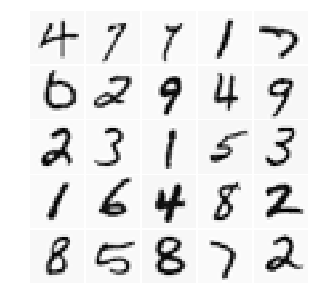

In [7]:
# Randomly select 100 data points to display - 25 is enough
idx_random = np.random.choice(m, 25, replace=False)
sel = X[idx_random, :]

displayData(sel, figsize= (5,5))

## 1.3 Vectorizing Logistic Regression

You will be using multiple one-vs-all logistic regression models to build a multi-class classifier. Since there are 10 classes, you will need to train 10 separate logistic regression classifiers. To make this training efficient, it is important to ensure that your code is well vectorized. In this section, you will implement a vectorized version of logistic regression that does not employ any `for` loops. You can use your code in the previous exercise as a starting point for this exercise. 

### 1.3.0 Test vectorized logistic regression (prev)

Create a test dataset    
dims: m x n  
dims: 5 rows x (1+3) features

In [8]:
# Teuse your regularized logistic regression code from the last exercise
# make sure its implementation is vectorized

# Test case for lrCostFunction
print('\nTesting if costFunction with regularization is vectorized')

#Custom test dataset
theta_t = np.array([-2, -1, 1, 2])
X_t_features = np.arange(1,16).reshape(5,3, order='F')/10.0
X_t = np.concatenate([np.ones((5,1)), X_t_features], axis=1)
y_t = np.array([1,0,1,0,1]) >= 0.5
       
print ("X test: \n", X_t)
print ("y test: ", y_t)

#set params
lambda_t = 3

#compute cost and gradient
J, grad = myML.costFunctionReg_LogisticR(theta_t, X_t, y_t, lambda_t)

#view cost and gradients
print('-----------------------')
print('Cost         : {:.6f}'.format(J))
print('Expected cost: 2.534819')
print('Gradients:')
print(' [{:.6f}, {:.6f}, {:.6f}, {:.6f}]'.format(*grad))
print('Expected gradients:')
print(' [0.146561, -0.548558, 0.724722, 1.398003]');


Testing if costFunction with regularization is vectorized
X test: 
 [[1.  0.1 0.6 1.1]
 [1.  0.2 0.7 1.2]
 [1.  0.3 0.8 1.3]
 [1.  0.4 0.9 1.4]
 [1.  0.5 1.  1.5]]
y test:  [ True False  True False  True]
-----------------------
Cost         : 2.534819
Expected cost: 2.534819
Gradients:
 [0.146561, -0.548558, 0.724722, 1.398003]
Expected gradients:
 [0.146561, -0.548558, 0.724722, 1.398003]


My previoius version of logistic regression (regularized and not) was implemented as vectorized, no internal loops.  Nothing to redo here.  It lives in myUtils and is ready to work with multiclass.


<a id="section1"></a>
### 1.3.1 Vectorizing the cost function - Review

We will begin by writing a vectorized version of the cost function. Recall that in (unregularized) logistic regression, the cost function is

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^m \left[ -y^{(i)} \log \left( h_\theta\left( x^{(i)} \right) \right) - \left(1 - y^{(i)} \right) \log \left(1 - h_\theta \left( x^{(i)} \right) \right) \right] $$

To compute each element in the summation, we have to compute $h_\theta(x^{(i)})$ for every example $i$, where $h_\theta(x^{(i)}) = g(\theta^T x^{(i)})$ and $g(z) = \frac{1}{1+e^{-z}}$ is the sigmoid function. It turns out that we can compute this quickly for all our examples by using matrix multiplication. Let us define $X$ and $\theta$ as

$$ X = \begin{bmatrix} - \left( x^{(1)} \right)^T - \\ - \left( x^{(2)} \right)^T - \\ \vdots \\ - \left( x^{(m)} \right)^T - \end{bmatrix} \qquad \text{and} \qquad \theta = \begin{bmatrix} \theta_0 \\ \theta_1 \\ \vdots \\ \theta_n \end{bmatrix} $$

Then, by computing the matrix product $X\theta$, we have: 

$$ X\theta = \begin{bmatrix} - \left( x^{(1)} \right)^T\theta - \\ - \left( x^{(2)} \right)^T\theta - \\ \vdots \\ - \left( x^{(m)} \right)^T\theta - \end{bmatrix} = \begin{bmatrix} - \theta^T x^{(1)}  - \\ - \theta^T x^{(2)} - \\ \vdots \\ - \theta^T x^{(m)}  - \end{bmatrix} $$

In the last equality, we used the fact that $a^Tb = b^Ta$ if $a$ and $b$ are vectors. This allows us to compute the products $\theta^T x^{(i)}$ for all our examples $i$ in one line of code.

#### 1.3.2 Vectorizing the gradient

Recall that the gradient of the (unregularized) logistic regression cost is a vector where the $j^{th}$ element is defined as

$$ \frac{\partial J }{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^m \left( \left( h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_j^{(i)} \right) $$

To vectorize this operation over the dataset, we start by writing out all the partial derivatives explicitly for all $\theta_j$,

$$
\begin{align*}
\begin{bmatrix} 
\frac{\partial J}{\partial \theta_0} \\
\frac{\partial J}{\partial \theta_1} \\
\frac{\partial J}{\partial \theta_2} \\
\vdots \\
\frac{\partial J}{\partial \theta_n}
\end{bmatrix} = &
\frac{1}{m} \begin{bmatrix}
\sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_0^{(i)}\right) \\
\sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_1^{(i)}\right) \\
\sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_2^{(i)}\right) \\
\vdots \\
\sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_n^{(i)}\right) \\
\end{bmatrix} \\
= & \frac{1}{m} \sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x^{(i)}\right) \\
= & \frac{1}{m} X^T \left( h_\theta(x) - y\right)
\end{align*}
$$

where

$$  h_\theta(x) - y = 
\begin{bmatrix}
h_\theta\left(x^{(1)}\right) - y^{(1)} \\
h_\theta\left(x^{(2)}\right) - y^{(2)} \\
\vdots \\
h_\theta\left(x^{(m)}\right) - y^{(m)} 
\end{bmatrix} $$

Note that $x^{(i)}$ is a vector, while $h_\theta\left(x^{(i)}\right) - y^{(i)}$  is a scalar (single number).
To understand the last step of the derivation, let $\beta_i = (h_\theta\left(x^{(m)}\right) - y^{(m)})$ and
observe that:

$$ \sum_i \beta_ix^{(i)} = \begin{bmatrix} 
| & | & & | \\
x^{(1)} & x^{(2)} & \cdots & x^{(m)} \\
| & | & & | 
\end{bmatrix}
\begin{bmatrix}
\beta_1 \\
\beta_2 \\
\vdots \\
\beta_m
\end{bmatrix} = x^T \beta
$$

where the values $\beta_i = \left( h_\theta(x^{(i)} - y^{(i)} \right)$.

The expression above allows us to compute all the partial derivatives
without any loops. If you are comfortable with linear algebra, we encourage you to work through the matrix multiplications above to convince yourself that the vectorized version does the same computations. 

Your job is to write the unregularized cost function `lrCostFunction` which returns both the cost function $J(\theta)$ and its gradient $\frac{\partial J}{\partial \theta}$. Your implementation should use the strategy we presented above to calculate $\theta^T x^{(i)}$. You should also use a vectorized approach for the rest of the cost function. A fully vectorized version of `lrCostFunction` should not contain any loops.

<div class="alert alert-box alert-warning">
**Debugging Tip:** Vectorizing code can sometimes be tricky. One common strategy for debugging is to print out the sizes of the matrices you are working with using the `shape` property of `numpy` arrays. For example, given a data matrix $X$ of size $100 \times 20$ (100 examples, 20 features) and $\theta$, a vector with size $20$, you can observe that `np.dot(X, theta)` is a valid multiplication operation, while `np.dot(theta, X)` is not. Furthermore, if you have a non-vectorized version of your code, you can compare the output of your vectorized code and non-vectorized code to make sure that they produce the same outputs.
</div>
<a id="lrCostFunction"></a>

<a id="section2"></a>
### 1.4 One-vs-all Classification

In this part of the exercise, you will implement one-vs-all classification by training multiple regularized logistic regression classifiers, one for each of the $K$ classes in our dataset. In the handwritten digits dataset, $K = 10$, but your code should work for any value of $K$. 

You should now complete the code for the function `oneVsAll` below, to train one classifier for each class. In particular, your code should return all the classifier parameters in a matrix $\theta \in \mathbb{R}^{K \times (N +1)}$, where each row of $\theta$ corresponds to the learned logistic regression parameters for one class. You can do this with a “for”-loop from $0$ to $K-1$, training each classifier independently.

Note that the `y` argument to this function is a vector of labels from 0 to 9. When training the classifier for class $k \in \{0, ..., K-1\}$, you will want a K-dimensional vector of labels $y$, where $y_j \in 0, 1$ indicates whether the $j^{th}$ training instance belongs to class $k$ $(y_j = 1)$, or if it belongs to a different
class $(y_j = 0)$. You may find logical arrays helpful for this task. 

Furthermore, you will be using scipy's `optimize.minimize` for this exercise. 
<a id="oneVsAll"></a>

In [9]:
def oneVsAll(X, y, num_labels, lambda_):
    """
    Trains num_labels logistic regression classifiers and returns each of these classifiers in 
    a matrix all_theta, where the i-th row of all_theta corresponds to the classifier for label i.
    
    Parameters
    ----------
    X : array_like
        The input dataset of shape (m x n+1) where
        m = total number of data points and
        n = number of features.
        We don't assume the intercept term is already in X, however we add the bias term to X here.
    
    y : array_like
        The data labels. A vector of shape (m, ).
    
    num_labels : int
        Number of possible labels.
    
    lambda_ : float
        The logistic regularization parameter.
    
    Returns
    -------
    all_theta : array_like
        The trained parameters for logistic regression for each class. A matrix of shape (K x n+1) where 
        K = number of classes (ie. `num_labels`) and 
        n = number of features without the bias.
    
    Hint
    ----
    Use y == c to obtain a vector of 1s and 0s that tell you whether the ground truth is true/false for this class.
    
    Note
    ----
    For this assignment, we recommend using `scipy.optimize.minimize(method='CG')`to optimize the cost function. 
    It is okay to use a for-loop (`for c in range(num_labels):`) to loop over the different classes.
    
    Example Code
    ------------
    
    # Set Initial theta
    initial_theta = np.zeros(n + 1)

    # Set options for minimize
    options = {'maxiter': 50}

    # Run minimize to obtain the optimal theta. This function will return a class object where theta is in `res.x` and cost in `res.fun`
    res = optimize.minimize(lrCostFunction, 
                            initial_theta, 
                            (X, (y == c), lambda_), 
                            jac=True, 
                            method='CG',
                            options=options) 
    """
    # Some useful variables
    m, n = X.shape
    
    # You need to return the following variables correctly 
    all_theta = np.zeros((num_labels, n + 1)) #$note: ok with looping
    
    # Add ones to the X data matrix
    X = np.concatenate([np.ones((m, 1)), X], axis=1)
    

    # ====================== YOUR CODE HERE ======================
    
    # Loop for each class
    for c in np.arange(num_labels):
        #print("Class: ", c)
        #use y value
        #y==c+1)[:,0]
        
        # Set Initial theta
        initial_theta = np.zeros(n+1)
        
        # Compute and display initial cost and gradient for regularized logistic regression
        #cost, grad = costFunctionReg_LogisticR(initial_theta, X, (y==c+1), lambda_) #$note: troubleshooting only
        
        # set options for optimize.minimize
        options= {'maxiter': 50}
        
        # Run minimize to obtain the optimal theta. 
        # This function will return a class object where theta is in `res.x` and cost in `res.fun`
        res = optimize.minimize(myML.costFunctionReg_LogisticR,
                            initial_theta,
                            (X, y==c+1, lambda_),
                            jac=True,
                            method='CG',
                            options=options)

        # returns the value of costFunction at optimized theta
        cost = res.fun
        # the optimized theta is in the x property
        theta = res.x
        

        # Print theta to screen
        ##print('Cost at theta found by optimize.minimize: {:.3f}'.format(cost))
        ##print('gradient: ', grad[0:2])
        #print('this theta: ', theta.shape)
        
        all_theta[c] = theta

    # ============================================================
    return all_theta #all_theta


Use your implementation to train a multi-class classifier. 

In [10]:
#compute all_theta
lambda_ = 0.1
all_theta = oneVsAll(X, y, 10, lambda_)
print('theta:')
print(all_theta)

theta:
[[-3.15820257e+00  0.00000000e+00  0.00000000e+00 ...  5.10461888e-03
   1.43045170e-07  0.00000000e+00]
 [-3.09035658e+00  0.00000000e+00  0.00000000e+00 ...  4.80377847e-03
  -5.49081342e-04  0.00000000e+00]
 [-4.88755714e+00  0.00000000e+00  0.00000000e+00 ... -4.91705016e-05
   6.70883341e-07  0.00000000e+00]
 ...
 [-8.92159114e+00  0.00000000e+00  0.00000000e+00 ... -1.21158443e-04
   1.16363919e-05  0.00000000e+00]
 [-4.77586600e+00  0.00000000e+00  0.00000000e+00 ... -1.12679536e-03
   8.70543585e-05  0.00000000e+00]
 [-8.92861047e+00  0.00000000e+00  0.00000000e+00 ... -3.74805784e-04
   2.12748741e-05  0.00000000e+00]]


### 1.4.1 One-vs-all Prediction

After training your one-vs-all classifier, you can now use it to predict the digit contained in a given image. For each input, you should compute the “probability” that it belongs to each class using the trained logistic regression classifiers. Your one-vs-all prediction function will pick the class for which the corresponding logistic regression classifier outputs the highest probability and return the class label (0, 1, ..., K-1) as the prediction for the input example. You should now complete the code in the function `predictOneVsAll` to use the one-vs-all classifier for making predictions. 

In [11]:
def predictOneVsAll(all_theta, X):
    """
    Return a vector of predictions for each example in the matrix X. 
    Note that X contains the examples in rows. 
    all_theta = a matrix where the i-th row is a trained logistic regression theta vector for the i-th class. 
    You should set p to a vector of values from 0..K-1 
    (i.e., p = [0, 2, 0, 1] predicts classes 0, 2, 0, 1 for 4 examples) .
    
    Parameters
    ----------
    all_theta : array_like
        The trained parameters for logistic regression for each class.  A matrix of shape (K x n+1) where 
        K = number of classes
        n = number of features without the bias.
    
    X : array_like
        Data points to predict their labels. This is a matrix of shape (m x n) where 
        m = number of data points to predict and 
        n = number of features without the bias term. 
        Note: we add the bias term for X in this function. 
    
    
    Returns
    -------
    p : array_like
        The predictions for each data point in X. This is a vector of shape (m, ).
    
    Instructions
    ------------
    Make predictions using your learned logistic regression parameters (one-vs-all). 
    You should set p to a vector of predictions (from 0 to num_labels-1).
    
    Hint
    ----
    This code can be done all vectorized using the numpy argmax function.
    argmax function returns the index of the max element,
    for more information see '?np.argmax' or search online. 
    If your examples are in rows, then, you can use np.argmax(A, axis=1) to obtain the index of the max for each row.
    """
    # set useful vars
    m = X.shape[0];
    num_labels = all_theta.shape[0]

    # need to return the following variables correctly 
    p = np.zeros(m)

    # Add ones to the X data matrix
    X = np.concatenate([np.ones((m, 1)), X], axis=1)

    # ====================== YOUR CODE HERE ======================
    #predict probability of this class
    y_hat = myML.sigmoid(np.dot(X, all_theta.T))
    
    #find index of best predicted class
    idx_best = np.argmax(y_hat, axis=1) #, out=p_idx)

    #format to prediction
    p = idx_best +1
    
    # ============================================================
    return p


Once you are done, call your `predictOneVsAll` function using the learned value of $\theta$. You should see that the training set accuracy is about 95.1% (i.e., it classifies 95.1% of the examples in the training set correctly).

In [12]:
pred = predictOneVsAll(all_theta, X)
print('Training Set Accuracy: ', (pred == y).mean())
print('Expected accuracy: 95.1 % (approx)\n')

Training Set Accuracy:  0.9512
Expected accuracy: 95.1 % (approx)



# 2. Neural Networks

In the previous part of this exercise, you implemented multi-class logistic regression to recognize handwritten digits. However, logistic regression cannot form more complex hypotheses as it is only a linear classifier (You could add more features - such as polynomial features - to logistic regression, but that can be very expensive to train).

In this part of the exercise, you will implement a neural network to recognize handwritten digits using the same training set as before. The neural network will be able to represent complex models that form non-linear hypotheses. For this week, you will be using parameters from a neural network that we have already trained. Your goal is to implement the feedforward propagation algorithm to use our weights for prediction. In next week’s exercise, you will write the backpropagation algorithm for learning the neural network parameters. 

We start by first reloading and visualizing the dataset which contains the MNIST handwritten digits (this is the same as we did in the first part of this exercise, we reload it here to ensure the variables have not been modified). 

In [13]:
X, y = data['X'], data['y'].ravel() #class numpy.ndarray
print("X shape: ", X.shape)
print("Preview X: ", X[:5])
print("\ny shape: ", y.shape)
print("Preview y: ",y[:5])

X shape:  (5000, 400)
Preview X:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

y shape:  (5000,)
Preview y:  [10 10 10 10 10]


In [14]:
#handle values of 10 due to 0 indexing
y[y == 10] = 0

## 2.1 Model representation 

Our neural network is shown in the following figure.

![Neural network](Figures/ex3_neuralnetwork.png)

It has 3 layers: an input layer, a hidden layer and an output layer. Recall that our inputs are pixel values of digit images. Since the images are of size 20×20, this gives us 400 input layer units (excluding the extra bias unit which always outputs +1). As before, the training data will be loaded into the variables X and y. 

You have been provided with a set of network parameters ($\Theta^{(1)}$, $\Theta^{(2)}$) already trained by us. These are stored in `ex3weights.mat`. The following cell loads those parameters into  `Theta1` and `Theta2`. The parameters have dimensions that are sized for a neural network with 25 units in the second layer and 10 output units (corresponding to the 10 digit classes).

In [15]:
# Setup the parameters you will use for this exercise
input_layer_size  = 400  # 20x20 Input Images of Digits
hidden_layer_size = 25   # 25 hidden units
num_labels = 10          # 10 labels, from 0 to 9

# Load the .mat file, which returns a dictionary 
weights = loadmat('data/ex3/ex3weights.mat') #class dict
#preview dict object
print(weights.keys())

# get the model weights from the dictionary
# Theta1 has size 25 x 401
# Theta2 has size 10 x 26
Theta1, Theta2 = weights['Theta1'], weights['Theta2']

# swap first and last columns of Theta2, due to legacy from MATLAB indexing, 
# since the weight file ex3weights.mat was saved based on MATLAB indexing
Theta2 = np.roll(Theta2, 1, axis=0)

dict_keys(['__header__', '__version__', '__globals__', 'Theta1', 'Theta2'])


<a id="section4"></a>
## 2.2 Feedforward Propagation and Prediction

Now you will implement feedforward propagation for the neural network. You will need to complete the code in the function `predict` to return the neural network’s prediction. You should implement the feedforward computation that computes $h_\theta(x^{(i)})$ for every example $i$ and returns the associated predictions. Similar to the one-vs-all classification strategy, the prediction from the neural network will be the label that has the largest output $\left( h_\theta(x) \right)_k$.

<div class="alert alert-box alert-warning">
**Implementation Note:** The matrix $X$ contains the examples in rows. When you complete the code in the function `predict`, you will need to add the column of 1’s to the matrix. The matrices `Theta1` and `Theta2` contain the parameters for each unit in rows. Specifically, the first row of `Theta1` corresponds to the first hidden unit in the second layer. In `numpy`, when you compute $z^{(2)} = \theta^{(1)}a^{(1)}$, be sure that you index (and if necessary, transpose) $X$ correctly so that you get $a^{(l)}$ as a 1-D vector.
</div>
<a id="predict"></a>

In [16]:
def predict(Theta1, Theta2, X):
    """
    Predict the label of an input given a trained neural network.
    
    Parameters
    ----------
    Theta1 : array_like
        Weights for the first layer in the neural network.
        It has shape (2nd hidden layer size x input size)
    
    Theta2: array_like
        Weights for the second layer in the neural network. 
        It has shape (output layer size x 2nd hidden layer size)
    
    X : array_like
        The image inputs having shape (number of examples x image dimensions).
    
    Return 
    ------
    p : array_like
        Predictions vector containing the predicted label for each example.
        It has a length equal to the number of examples.
    
    Instructions
    ------------
    Make predictions using your learned neural network. 
    You should set p to a vector containing labels between 0 to (num_labels-1).
     
    Hint
    ----
    This code can be done all vectorized using the numpy argmax function.
    In particular, the argmax function returns the index of the  max element,
    for more information see '?np.argmax' or search online. 
    If your examples are in rows, then, you can use np.argmax(A, axis=1) to obtain the index of the max for each row.
    
    Note
    ----
    Reuse `sigmoid` function in myUtils.
    Replace `z` by the required input variable to sigmoid.
    """
    # Make sure the input has two dimensions
    if X.ndim == 1:
        X = X[None]  # promote to 2-dimensions
    
    # Some useful variables
    m = X.shape[0]
    
    # Add ones to the input X data matrix
    X = np.concatenate([np.ones((m, 1)), X], axis=1)
    
    # You need to return the following variables correctly 
    p = np.zeros(X.shape[0])

    # ====================== YOUR CODE HERE ======================
    
    #compute 2nd (hidden) layer a2
    a2 = myML.sigmoid(np.dot(X, Theta1.T)) #dims (5000x401) x (401x25) => dims 5000x25
    
    # Add ones to the a2 (2nd layer) data matrix
    a2 = np.concatenate([np.ones((m, 1)), a2], axis=1)
    
    #compute output layer a3 
    a3 = myML.sigmoid(np.dot(a2, Theta2.T)) #dims (5000x26) x (26x10) => dims 5000x10
    #a3 represents the output layer, or probability of each class, each record with 10 probabilities
    
    #find index of best predicted class
    idx_best = np.argmax(a3, axis=1)

    #format to prediction
    p = idx_best #dims (5000,) vector

    # =============================================================
    return p


Once you are done, call your predict function using the loaded set of parameters for `Theta1` and `Theta2`. You should see that the accuracy is about 97.5%.

In [17]:
#call predict function
pred = predict(Theta1, Theta2, X)
print("Prediction shape: ", pred.shape)
print('Training Set Accuracy: {:.3f}%'.format((pred == y).mean()))
print('Expected accuracy: 97.5 % (approx)\n')

Prediction shape:  (5000,)
Training Set Accuracy: 0.975%
Expected accuracy: 97.5 % (approx)



After that, we will display images from the training set one at a time, while at the same time printing out the predicted label for the displayed image. 

Run the following cell to display a single image the the neural network's prediction. You can run the cell multiple time to see predictions for different images.

[4 7 7 1 7 0 2 9 4 9 2 3 1 5 3 1 6 4 8 2 8 5 8 7 2]


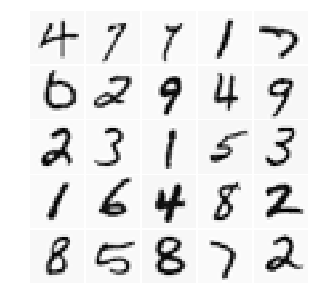

In [18]:
pred = predict(Theta1, Theta2, X[idx_random])
print(pred.ravel())
displayData(X[idx_random], figsize= (5,5))

In [19]:
stop

NameError: name 'stop' is not defined

## Xtra

In [ ]:
#$xtra: for troubleshooting only: logReg regularized here
#use myML
def costFunctionReg_LogisticR(theta, X, y, lambda_=1):
    """
    Compute cost and gradient for logistic regression with regularization.

    Parameters
    ----------
    theta : array_like
        Logistic regression parameters. A vector with shape (n, ).
        n = number of features including any intercept.
        If we have mapped our initial features into polynomial features, then
        n = the total number of polynomial features.

    X : array_like
        The input dataset with shape (m x n) where
        m = total number of data points and
        n = number of features (after feature mapping).
        We assume the intercept has already been added to the input.

    y : array_like
        The data labels. A vector with shape (m, ).

    lambda_ : float
        The regularization parameter.

    Returns
    -------
    J : float
        The computed value for the regularized cost function.

    grad : array_like
        A vector of shape (n, ) which is the gradient of the cost J with respect to theta, at the current values of theta.

    Instructions
    ------------
    Compute J cost of a particular choice of theta.
    Compute the partial derivatives and set grad to the partial derivatives of the cost w.r.t. each param in theta.
    Note: Remember not to regularize param theta0 => explicitly exlude theta0 from cost function J

    myNotes revised
    =========
    y_hat = X * theta => (m, n+1) x (n+1, ) x  => shape (m, )     (same as y)
    error = y_hat - y =>                          shape (m, )     (same as y)
    gradient = vector                             shape (n+1, )   (same as theta)
    X.T * (error/m) => (n+1, m) x (m, 1) =>       shape (n+1, )

    to multiply: use np.dot(X, theta)

    refer: https://docs.scipy.org/doc/numpy/reference/generated/numpy.dot.html
    """
    ##print("fn theta shape: ", theta.shape)
    

    # Initialize vars
    m = y.size  # number of training examples

    # convert labels to ints if their type is bool
    if y.dtype == bool:
        y = y.astype(int)

    # Return the following variables correctly
    J = 0
    grad = np.zeros(theta.shape)

    # ====================== YOUR CODE HERE ======================
    # compute hypothesis
    # for linear regression was: y_hat = np.dot( X, theta)
    # for logistic regression
    ##print("fn theta shape: ", theta.shape)
    y_hat = myML.sigmoid(np.dot(X, theta))
    ##print("fn y_hat shape: ",y_hat.shape)

    # compute cost
    ##print("part 1 y: ", y.shape)
    ##print("part 1: ", np.log(y_hat).shape)
    part1 = -y * np.log(y_hat)
    part2 = (1 - y) * np.log(1 - y_hat)
    # exclude theta0 from regularizing
    J = ((part1 - part2).sum() / m) + (lambda_ * (theta[1:] ** 2).sum() / (2 * m))

    # compute gradient -> hint: same dimension as theta, see myNotes
    # error = y_hat - y
    # grad = np.dot(X.T, (error/m))

    # exclude theta0 from regularizing => separately compute gradient0
    grad[0] = np.dot(X[:, 0], (y_hat - y) / m)  # returns a scalar (1 x m) x (m x 1), same for np.dot((m,)x(m,))

    # y_hat_rest = myML.sigmoid( np.dot(X[:,1:], theta[1:]))
    grad[1:] = np.dot(X[:, 1:].T, (y_hat - y) / m) + (lambda_ * theta[1:] / m)  # same dims as theta - 1

    # =============================================================
    return J, grad
